In [1]:
!pip install jupyter pandas "sqlalchemy<2.0" pymysql seaborn pillow scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.7 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.31
    Uninstalling SQLAlchemy-2.0.31:
      Successfully uninstalled SQLAlchemy-2.0.31
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.52 which is incompatible.


In [2]:
from time import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay



In [3]:
import pandas as pd
from sqlalchemy import create_engine, exc

def load_table(table_name, engine):
    try:
        df_table = pd.read_sql(f"SELECT * FROM {table_name}", engine)
        return df_table
    except exc.SQLAlchemyError as e:
        print(f"Error al cargar la tabla '{table_name}': {str(e)}")
        return None

# Configurar la conexión a la base de datos
db_username = 'guest'
db_password = 'relational'
db_host = 'db.relational-data.org'
db_port = 3306
db_database = 'Shakespeare'

# Crear la URL de conexión
db_url = f"mysql+pymysql://{db_username}:{db_password}@{db_host}:{db_port}/{db_database}"

# Crear el motor de SQLAlchemy
engine = create_engine(db_url)

# Cargar las tablas necesarias
df_paragraphs = load_table("paragraphs", engine)
df_chapters = load_table("chapters", engine)
df_works = load_table("works", engine)
df_characters = load_table("characters", engine)

# Verificar si todas las tablas se cargaron correctamente
if df_paragraphs is None or df_chapters is None or df_works is None or df_characters is None:
    print("Error al cargar una o más tablas.")
else:
    # Agregar personajes, obras y géneros en el mismo dataset
    df_dataset = df_paragraphs.merge(df_chapters.set_index("id")["work_id"], left_on="chapter_id", right_index=True)
    df_dataset = df_dataset.merge(df_works.set_index("id")[["Title", "GenreType"]], left_on="work_id", right_index=True)
    df_dataset = df_dataset.merge(df_characters.set_index('id')["CharName"], left_on="character_id", right_index=True).sort_index()

    # Mostrar el dataset resultante
    print(df_dataset.head())


       id  ParagraphNum                                          PlainText  \
0  630863             3  [Enter DUKE ORSINO, CURIO, and other Lords; Mu...   
1  630864             4  If music be the food of love, play on;\nGive m...   
2  630865            19                         Will you go hunt, my lord?   
3  630866            20                                       What, Curio?   
4  630867            21                                          The hart.   

   character_id  chapter_id  work_id          Title GenreType  \
0          1261       18704        1  Twelfth Night    Comedy   
1           840       18704        1  Twelfth Night    Comedy   
2           297       18704        1  Twelfth Night    Comedy   
3           840       18704        1  Twelfth Night    Comedy   
4           297       18704        1  Twelfth Night    Comedy   

             CharName  
0  (stage directions)  
1              Orsino  
2               Curio  
3              Orsino  
4               Curi

In [4]:
df_paragraphs

,id,ParagraphNum,PlainText,character_id,chapter_id
0,630863,3,"[Enter DUKE ORSINO, CURIO, and other Lords; Mu...",1261,18704
1,630864,4,"If music be the food of love, play on;\nGive m...",840,18704
2,630865,19,"Will you go hunt, my lord?",297,18704
3,630866,20,"What, Curio?",840,18704
4,630867,21,The hart.,297,18704
...,...,...,...,...,...
35460,666323,3460,"That she is living,\nWere it but told you, sho...",866,19648
35461,666324,3467,"You gods, look down\nAnd from your sacred vial...",584,19648
35462,666325,3475,There's time enough for that;\nLest they desir...,866,19648
35463,666326,3483,"O, peace, Paulina!\nThou shouldst a husband ta...",667,19648


In [5]:
# TODO: Actualizar con su versión de clean_text() de la Tarea_1

def clean_text(df, column_name):
    # Convertir todo a minúsculas
    result = df[column_name].str.lower()

    # FIXME: completar
    for punc in ["[", "\n", ","]:
        result = result.str.replace(punc, " ")
    return result

# Creamos una nueva columna CleanText a partir de PlainText
df_paragraphs["CleanText"] = clean_text(df_paragraphs, "PlainText")

# Veamos la diferencia
df_paragraphs[["PlainText", "CleanText"]]

,PlainText,CleanText
0,"[Enter DUKE ORSINO, CURIO, and other Lords; Mu...",enter duke orsino curio and other lords; mu...
1,"If music be the food of love, play on;\nGive m...",if music be the food of love play on; give me...
2,"Will you go hunt, my lord?",will you go hunt my lord?
3,"What, Curio?",what curio?
4,The hart.,the hart.
...,...,...
35460,"That she is living,\nWere it but told you, sho...",that she is living were it but told you shou...
35461,"You gods, look down\nAnd from your sacred vial...",you gods look down and from your sacred vials...
35462,There's time enough for that;\nLest they desir...,there's time enough for that; lest they desire...
35463,"O, peace, Paulina!\nThou shouldst a husband ta...",o peace paulina! thou shouldst a husband tak...


In [6]:
# Agregamos personajes, obras y géneros en el mismo dataset
df_dataset = df_paragraphs.merge(df_chapters.set_index("id")["work_id"], left_on="chapter_id", right_index=True)
df_dataset = df_dataset.merge(df_works.set_index("id")[["Title", "GenreType"]], left_on="work_id", right_index=True)
df_dataset = df_dataset.merge(df_characters.set_index('id')["CharName"], left_on="character_id", right_index=True).sort_index()
df_dataset = df_dataset[["CleanText", "CharName", "Title", "GenreType"]]

# Usaremos estos personajes
characters = ["Antony", "Cleopatra", "Hamlet"]
df_dataset = df_dataset[df_dataset["CharName"].isin(characters)]

df_dataset

,CleanText,CharName,Title,GenreType
2058,if it be love indeed tell me how much.,Cleopatra,Antony and Cleopatra,Tragedy
2059,there's beggary in the love that can be reckon'd.,Antony,Antony and Cleopatra,Tragedy
2060,i'll set a bourn how far to be beloved.,Cleopatra,Antony and Cleopatra,Tragedy
2061,then must thou needs find out new heaven new ...,Antony,Antony and Cleopatra,Tragedy
2064,grates me: the sum.,Antony,Antony and Cleopatra,Tragedy
...,...,...,...,...
15300,villains you did not so when your vile dagge...,Antony,Julius Caesar,Tragedy
15307,old cassius still!,Antony,Julius Caesar,Tragedy
15380,where is he?,Antony,Julius Caesar,Tragedy
15382,this is not brutus friend; but i assure you ...,Antony,Julius Caesar,Tragedy


In [7]:
# Párrafos por cada personaje seleccionado
df_dataset["CharName"].value_counts()

CharName
Hamlet       358
Antony       253
Cleopatra    204
Name: count, dtype: int64

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Definir la función clean_text
def clean_text(df, column_name):
    result = df[column_name].str.lower()
    # Especificar los signos de puntuación que se desean eliminar
    punctuation = ["\[", "\n", ",", "\.", ";", "¿", "\?", "!", "¡", "\"", "\(", "\)", "\]", "-", "'", ":"]
    for punc in punctuation:
        result = result.str.replace(punc, " ", regex=True)
    return result

# Crear una nueva columna CleanText a partir de PlainText
df_paragraphs["CleanText"] = clean_text(df_paragraphs, "PlainText")

# Crear un DataFrame combinando las tablas
df_dataset = df_paragraphs.merge(df_chapters.set_index("id")["work_id"], left_on="chapter_id", right_index=True)
df_dataset = df_dataset.merge(df_works.set_index("id")[["Title", "GenreType"]], left_on="work_id", right_index=True)
df_dataset = df_dataset.merge(df_characters.set_index('id')["CharName"], left_on="character_id", right_index=True).sort_index()

# Filtrar para obtener un Dataset reducido de solo 3 personajes
selected_characters = ["Cleopatra", "Hamlet", "Antony"]  # Nombres de los personajes actualizados
df_reduced = df_dataset[df_dataset["CharName"].isin(selected_characters)]

# Convertir las columnas específicas a arreglos de NumPy
X = df_reduced["CleanText"].to_numpy()
y = df_reduced["CharName"].to_numpy()

# Dividir los datos en conjunto de entrenamiento y prueba con muestreo estratificado
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Mostrar algunos ejemplos del conjunto de entrenamiento y prueba
print("Ejemplos del conjunto de entrenamiento:")
for i in range(3):
    print(f"Texto: {X_train[i]}, Personaje: {y_train[i]}")

print("\nEjemplos del conjunto de prueba:")
for i in range(3):
    print(f"Texto: {X_test[i]}, Personaje: {y_test[i]}")



Ejemplos del conjunto de entrenamiento:
Texto: what have i kept back , Personaje: Cleopatra
Texto: my salad days  when i was green in judgment  cold in blood  to say as i said then  but  come  away  get me ink and paper  he shall have every day a several greeting  or i ll unpeople egypt , Personaje: Cleopatra
Texto: if not denounced against us  why should not we be there in person , Personaje: Cleopatra

Ejemplos del conjunto de prueba:
Texto: our overplus of shipping will we burn  and  with the rest full mann d  from the head of actium beat the approaching caesar  but if we fail  we then can do t at land   enter a messenger  thy business , Personaje: Antony
Texto: go on  right royal , Personaje: Cleopatra
Texto: come on  sir , Personaje: Hamlet


In [10]:
# Convertir las columnas específicas a arreglos de NumPy
X = df_reduced["CleanText"].to_numpy()
y = df_reduced["CharName"].to_numpy()

# TODO: Partir train/test 30% estratificados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Imprimir los tamaños de los conjuntos de entrenamiento y prueba
print(f"Tamaños de Train/Test: {len(X_train)}/{len(X_test)}")

# Mostrar algunos ejemplos del conjunto de entrenamiento y prueba
print("Ejemplos del conjunto de entrenamiento:")
for i in range(3):
    print(f"Texto: {X_train[i]}, Personaje: {y_train[i]}")

print("\nEjemplos del conjunto de prueba:")
for i in range(3):
    print(f"Texto: {X_test[i]}, Personaje: {y_test[i]}")

Tamaños de Train/Test: 570/245
Ejemplos del conjunto de entrenamiento:
Texto: what have i kept back , Personaje: Cleopatra
Texto: my salad days  when i was green in judgment  cold in blood  to say as i said then  but  come  away  get me ink and paper  he shall have every day a several greeting  or i ll unpeople egypt , Personaje: Cleopatra
Texto: if not denounced against us  why should not we be there in person , Personaje: Cleopatra

Ejemplos del conjunto de prueba:
Texto: our overplus of shipping will we burn  and  with the rest full mann d  from the head of actium beat the approaching caesar  but if we fail  we then can do t at land   enter a messenger  thy business , Personaje: Antony
Texto: go on  right royal , Personaje: Cleopatra
Texto: come on  sir , Personaje: Hamlet


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Definir la función clean_text
def clean_text(df, column_name):
    result = df[column_name].str.lower()
    # Especificar los signos de puntuación que se desean eliminar
    punctuation = ["\[", "\n", ",", "\.", ";", "¿", "\?", "!", "¡", "\"", "\(", "\)", "\]", "-", "'", ":"]
    for punc in punctuation:
        result = result.str.replace(punc, " ", regex=True)
    return result

# Crear una nueva columna CleanText a partir de PlainText
df_paragraphs["CleanText"] = clean_text(df_paragraphs, "PlainText")

# Crear un DataFrame combinando las tablas
df_dataset = df_paragraphs.merge(df_chapters.set_index("id")["work_id"], left_on="chapter_id", right_index=True)
df_dataset = df_dataset.merge(df_works.set_index("id")[["Title", "GenreType"]], left_on="work_id", right_index=True)
df_dataset = df_dataset.merge(df_characters.set_index('id')["CharName"], left_on="character_id", right_index=True).sort_index()

# Filtrar para obtener un Dataset reducido de solo 3 personajes
selected_characters = ["Cleopatra", "Hamlet", "Antony"]  # Nombres de los personajes actualizados
df_reduced = df_dataset[df_dataset["CharName"].isin(selected_characters)]

# Convertir las columnas específicas a arreglos de NumPy
X = df_reduced["CleanText"].to_numpy()
y = df_reduced["CharName"].to_numpy()

# TODO: Partir train/test 30% estratificados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Verificar la estructura de train_distribution
train_distribution = pd.Series(y_train).value_counts(normalize=True)
print(train_distribution.head())

# Imprimir los tamaños de los conjuntos de entrenamiento y prueba
print(f"Tamaños de Train/Test: {len(X_train)}/{len(X_test)}")

# Mostrar algunos ejemplos del conjunto de entrenamiento y prueba
print("Ejemplos del conjunto de entrenamiento:")
for i in range(3):
    print(f"Texto: {X_train[i]}, Personaje: {y_train[i]}")

print("\nEjemplos del conjunto de prueba:")
for i in range(3):
    print(f"Texto: {X_test[i]}, Personaje: {y_test[i]}")


Hamlet       0.438596
Antony       0.310526
Cleopatra    0.250877
Name: proportion, dtype: float64
Tamaños de Train/Test: 570/245
Ejemplos del conjunto de entrenamiento:
Texto: what have i kept back , Personaje: Cleopatra
Texto: my salad days  when i was green in judgment  cold in blood  to say as i said then  but  come  away  get me ink and paper  he shall have every day a several greeting  or i ll unpeople egypt , Personaje: Cleopatra
Texto: if not denounced against us  why should not we be there in person , Personaje: Cleopatra

Ejemplos del conjunto de prueba:
Texto: our overplus of shipping will we burn  and  with the rest full mann d  from the head of actium beat the approaching caesar  but if we fail  we then can do t at land   enter a messenger  thy business , Personaje: Antony
Texto: go on  right royal , Personaje: Cleopatra
Texto: come on  sir , Personaje: Hamlet


   Character  proportion
0     Hamlet    0.438596
1     Antony    0.310526
2  Cleopatra    0.250877


<Figure size 1200x600 with 0 Axes>

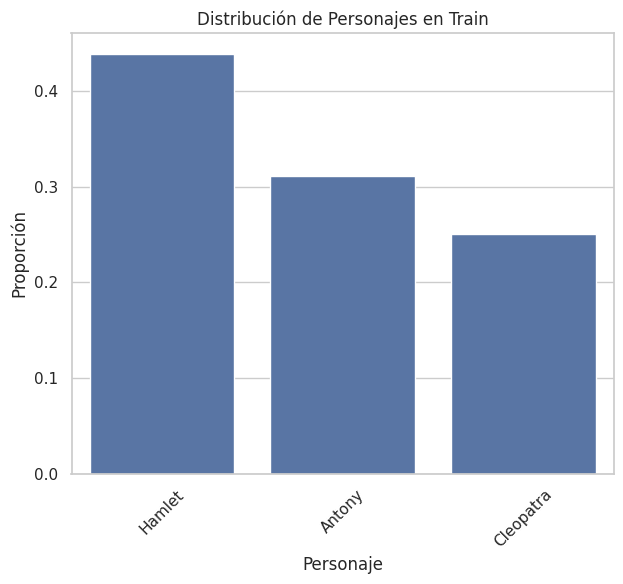

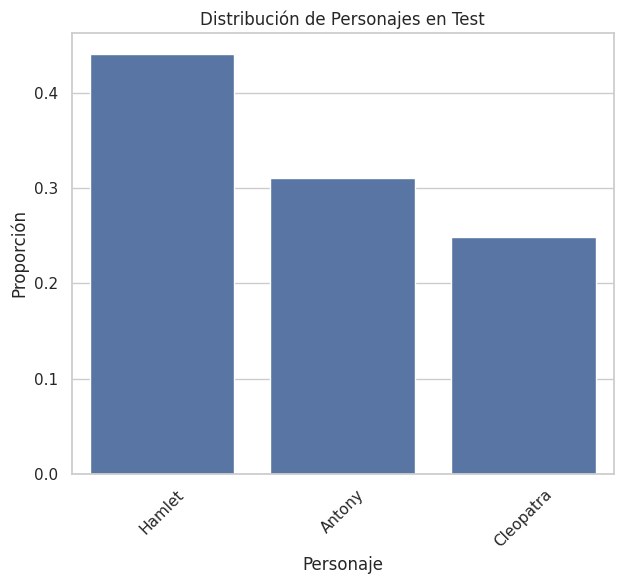

<Figure size 640x480 with 0 Axes>

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Definir la función clean_text
def clean_text(df, column_name):
    result = df[column_name].str.lower()
    # Especificar los signos de puntuación que se desean eliminar
    punctuation = ["\[", "\n", ",", "\.", ";", "¿", "\?", "!", "¡", "\"", "\(", "\)", "\]", "-", "'", ":"]
    for punc in punctuation:
        result = result.str.replace(punc, " ", regex=True)
    return result

# Crear una nueva columna CleanText a partir de PlainText
df_paragraphs["CleanText"] = clean_text(df_paragraphs, "PlainText")

# Crear un DataFrame combinando las tablas
df_dataset = df_paragraphs.merge(df_chapters.set_index("id")["work_id"], left_on="chapter_id", right_index=True)
df_dataset = df_dataset.merge(df_works.set_index("id")[["Title", "GenreType"]], left_on="work_id", right_index=True)
df_dataset = df_dataset.merge(df_characters.set_index('id')["CharName"], left_on="character_id", right_index=True).sort_index()

# Filtrar para obtener un Dataset reducido de solo 3 personajes
selected_characters = ["Cleopatra", "Hamlet", "Antony"]
df_reduced = df_dataset[df_dataset["CharName"].isin(selected_characters)]

# Convertir las columnas específicas a arreglos de NumPy
X = df_reduced["CleanText"].to_numpy()
y = df_reduced["CharName"].to_numpy()

# Dividir los datos en conjunto de entrenamiento y prueba con muestreo estratificado
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Crear DataFrames para los conjuntos de entrenamiento y prueba
df_train = pd.DataFrame({"Text": X_train, "Character": y_train})
df_test = pd.DataFrame({"Text": X_test, "Character": y_test})

# Calcular la distribución de personajes en train y test
train_distribution = df_train["Character"].value_counts(normalize=True).reset_index()
test_distribution = df_test["Character"].value_counts(normalize=True).reset_index()

# Configurar el estilo y tamaño del gráfico
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Verificar la estructura de train_distribution
print(train_distribution.head())

# Graficar la distribución de personajes en train
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x="Character", y="proportion", data=train_distribution)
plt.title('Distribución de Personajes en Train')
plt.xlabel('Personaje')
plt.ylabel('Proporción')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Graficar la distribución de personajes en test
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
sns.barplot(x="Character", y="proportion", data=test_distribution)
plt.title('Distribución de Personajes en Test')
plt.xlabel('Personaje')
plt.ylabel('Proporción')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Ajustar el espacio entre subplots y mostrar el gráfico
plt.tight_layout()
plt.show()


Conteo de palabras y TF-IDF

In [14]:
count_vect = CountVectorizer(stop_words=None, ngram_range=(1,1))
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts

<570x3235 sparse matrix of type '<class 'numpy.int64'>'
	with 13552 stored elements in Compressed Sparse Row format>

In [15]:
tf_idf = TfidfTransformer(use_idf=False)
X_train_tf = tf_idf.fit_transform(X_train_counts)
X_train_tf

<570x3235 sparse matrix of type '<class 'numpy.float64'>'
	with 13552 stored elements in Compressed Sparse Row format>

Reducción de dimensionalidad

In [16]:
# TODO: Realizar PCA sobre los datos de entrenamiento
from sklearn.decomposition import PCA
reductor = PCA(n_components=2)
# Transformar train
X_train_red = reductor.fit_transform(X_train_tf.toarray())

print("Shape of reduced training data:", X_train_red.shape)
print("Reduced training data:\n", X_train_red)

Shape of reduced training data: (570, 2)
Reduced training data:
 [[-0.19465377 -0.07279321]
 [ 0.033809    0.0007549 ]
 [-0.13091106 -0.06309272]
 ...
 [-0.22217755 -0.1158053 ]
 [ 0.01917531  0.13468137]
 [-0.19483039 -0.27515107]]


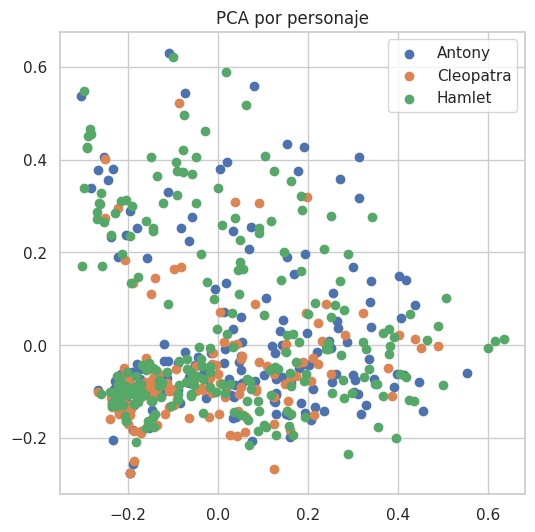

In [17]:
# Visualización de las dos primeras componentes de PCA
fig, ax = plt.subplots(figsize=(6, 6))
for character in np.unique(y_train):
    mask_train = y_train == character
    ax.scatter(X_train_red[mask_train, 0], X_train_red[mask_train, 1], label=character)

ax.set_title("PCA por personaje")
ax.legend()

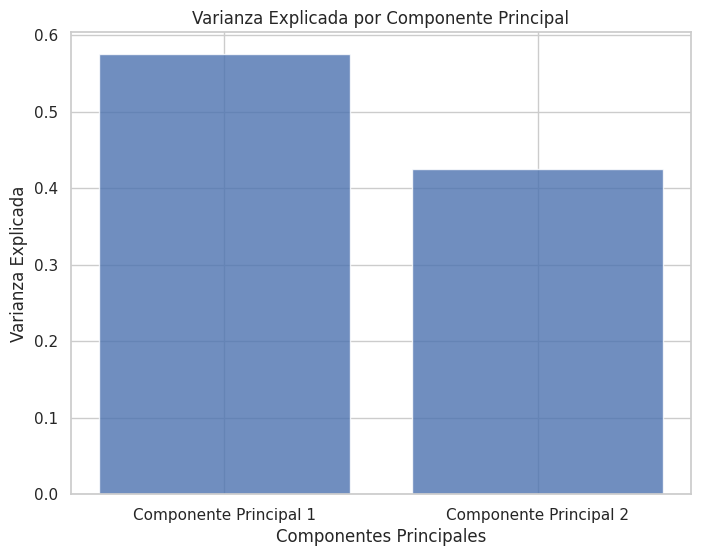

Varianza explicada acumulada:
 [0.57508252 1.        ]


In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Supongamos que tienes X_train_red, que es tu conjunto de datos transformado por PCA

# Crear instancia de PCA
pca = PCA(n_components=2)

# Ajustar PCA a los datos de entrenamiento
X_train_pca = pca.fit_transform(X_train_red)

# Obtener la varianza explicada por cada componente principal
variance_explained = pca.explained_variance_ratio_

# Visualizar la varianza explicada
plt.figure(figsize=(8, 6))
plt.bar(range(len(variance_explained)), variance_explained, alpha=0.8, align='center')
plt.xlabel('Componentes Principales')
plt.ylabel('Varianza Explicada')
plt.title('Varianza Explicada por Componente Principal')
plt.xticks(range(len(variance_explained)), ['Componente Principal 1', 'Componente Principal 2'])
plt.show()

# Suma acumulada de varianza explicada
cumulative_variance_explained = np.cumsum(variance_explained)
print("Varianza explicada acumulada:\n", cumulative_variance_explained)

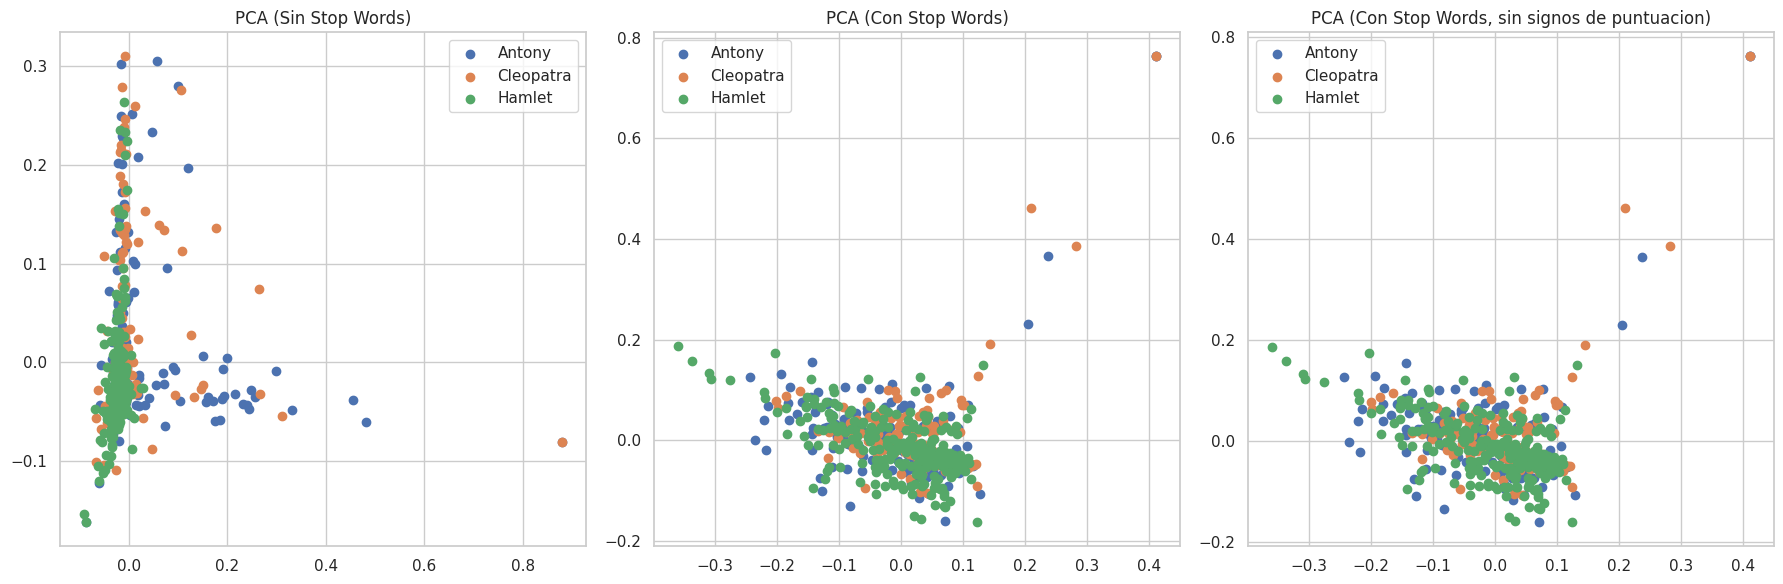

In [19]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Configuración 1: Sin stop words, con TF-IDF y ngram_range=(1,2)
count_vect_1 = CountVectorizer(stop_words='english', ngram_range=(1, 2))
X_train_counts_1 = count_vect_1.fit_transform(X_train)
tf_idf_1 = TfidfTransformer(use_idf=True)
X_train_tf_1 = tf_idf_1.fit_transform(X_train_counts_1)

reductor_1 = PCA(n_components=2)
X_train_red_1 = reductor_1.fit_transform(X_train_tf_1.toarray())

# Configuración 2: Con stop words para inglés, con TF-IDF y ngram_range=(1,2)
count_vect_2 = CountVectorizer(stop_words=None, ngram_range=(1, 2))
X_train_counts_2 = count_vect_2.fit_transform(X_train)
tf_idf_2 = TfidfTransformer(use_idf=True)
X_train_tf_2 = tf_idf_2.fit_transform(X_train_counts_2)

reductor_2 = PCA(n_components=2)
X_train_red_2 = reductor_2.fit_transform(X_train_tf_2.toarray())

# Configuración 3: Con stop words para inglés y sin eliminar signos de puntuación, con TF-IDF y ngram_range=(1,2)
count_vect_3 = CountVectorizer(stop_words=None, ngram_range=(1, 2))
X_train_counts_3 = count_vect_3.fit_transform(X_train)
tf_idf_3 = TfidfTransformer(use_idf=True)
X_train_tf_3 = tf_idf_3.fit_transform(X_train_counts_3)

reductor_3 = PCA(n_components=2)
X_train_red_3 = reductor_3.fit_transform(X_train_tf_3.toarray())

# Visualización de las dos primeras componentes de PCA para cada configuración
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Configuración 1: Sin stop words
axes[0].set_title("PCA (Sin Stop Words)")
for character in np.unique(y_train):
    mask = y_train == character
    axes[0].scatter(X_train_red_1[mask, 0], X_train_red_1[mask, 1], label=character)
axes[0].legend()

# Configuración 2: Con stop words
axes[1].set_title("PCA (Con Stop Words)")
for character in np.unique(y_train):
    mask = y_train == character
    axes[1].scatter(X_train_red_2[mask, 0], X_train_red_2[mask, 1], label=character)
axes[1].legend()

# Configuración 3: Con stop words y sin eliminar signos de puntuación
axes[2].set_title("PCA (Con Stop Words, sin signos de puntuacion)")
for character in np.unique(y_train):
    mask = y_train == character
    axes[2].scatter(X_train_red_3[mask, 0], X_train_red_3[mask, 1], label=character)
axes[2].legend()

plt.tight_layout()
plt.show()



Modelos de Clasificación

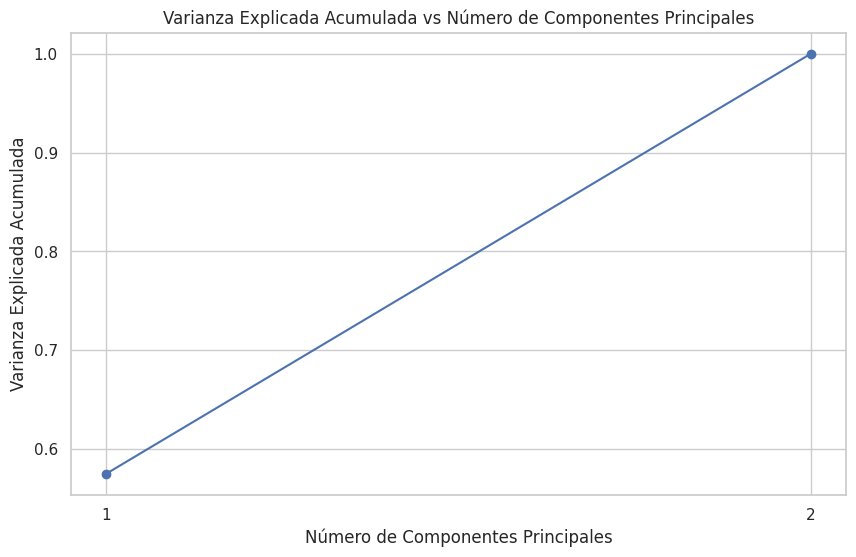

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Número máximo de componentes para considerar
max_components = 10

# Lista para almacenar la varianza explicada acumulada
explained_variance_ratio_cumulative = []

# Iterar sobre diferentes números de componentes principales
for n_components in range(1, min(max_components, X_train_red.shape[1]) + 1):
    # Crear instancia de PCA
    pca = PCA(n_components=n_components)

    # Ajustar PCA a los datos de entrenamiento
    X_train_pca = pca.fit_transform(X_train_red)

    # Obtener la varianza explicada por cada componente principal
    variance_explained = pca.explained_variance_ratio_

    # Varianza explicada acumulada
    cumulative_variance_explained = np.sum(variance_explained)

    # Agregar a la lista de varianza explicada acumulada
    explained_variance_ratio_cumulative.append(cumulative_variance_explained)

# Graficar la varianza explicada acumulada en función del número de componentes
plt.figure(figsize=(10, 6))
plt.plot(range(1, min(max_components, X_train_red.shape[1]) + 1), explained_variance_ratio_cumulative, marker='o', linestyle='-', color='b')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada vs Número de Componentes Principales')
plt.xticks(range(1, min(max_components, X_train_red.shape[1]) + 1))
plt.grid(True)
plt.show()


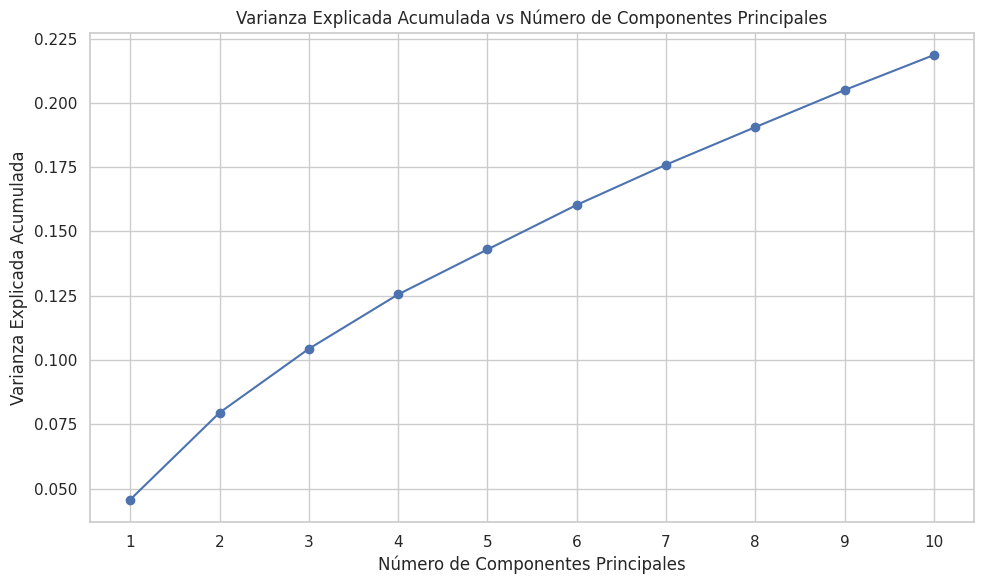

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Ajustar PCA con hasta 10 componentes sobre los datos originales de entrenamiento transformados
n_components = 10
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_tf.toarray())

# Obtener la varianza explicada por cada componente principal
variance_explained = pca.explained_variance_ratio_

# Calcular la varianza explicada acumulada
cumulative_variance_explained = np.cumsum(variance_explained)

# Preparar el gráfico
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, n_components + 1), cumulative_variance_explained, marker='o', linestyle='-', color='b')

# Configurar etiquetas y título
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada vs Número de Componentes Principales')

# Mostrar el gráfico
plt.grid(True)
plt.xticks(np.arange(1, n_components + 1))
plt.tight_layout()
plt.show()


In [22]:
bayes_clf = MultinomialNB().fit(X_train_tf, y_train)

# Ver las primeras 10 predicciones de train
y_pred_train = bayes_clf.predict(X_train_tf)
y_pred_train[:10]

array(['Cleopatra', 'Hamlet', 'Hamlet', 'Antony', 'Hamlet', 'Hamlet',
       'Hamlet', 'Hamlet', 'Hamlet', 'Hamlet'], dtype='<U9')

In [23]:
def get_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum() / len(y_true)

get_accuracy(y_train, y_pred_train)

0.6192982456140351

Búsqueda de hiper-parámetros con Cross-Validation

In [25]:
pip install --upgrade matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 30.3 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1


Parámetros: {'stop_words': None, 'ngram': (1, 2), 'idf': True}
Accuracy promedio: 0.4701 ± 0.0252

Parámetros: {'stop_words': None, 'ngram': (1, 1), 'idf': False}
Accuracy promedio: 0.4824 ± 0.0262



<ipython-input-26-562e4dafd01a>:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=results["params"], y=results["accuracy"], palette="Set3")


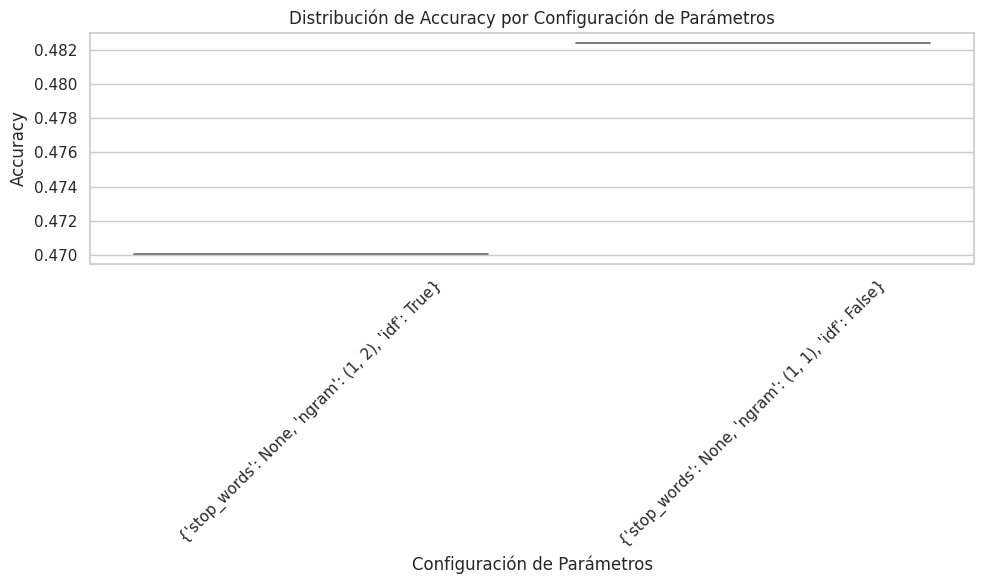

In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Definir variantes de parámetros
param_sets = [
    {"stop_words": None, "ngram": (1, 2), "idf": True},
    {"stop_words": None, "ngram": (1, 1), "idf": False}
]

# Configurar validación cruzada estratificada
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Para almacenar resultados de métricas
results = {"params": [], "accuracy": []}

# Preparar el desarrollo del dataset (train + validation)
X_dev = X_train
y_dev = y_train

for params in param_sets:

    # Transformaciones a aplicar (featurizers)
    count_vect = CountVectorizer(stop_words=params["stop_words"], ngram_range=params["ngram"])
    tf_idf = TfidfTransformer(use_idf=params["idf"])

    accuracies = []

    for train_idxs, val_idxs in skf.split(X_dev, y_dev):

        # Obtener train y validation para el split actual
        X_train_ = X_dev[train_idxs]
        y_train_ = y_dev[train_idxs]
        X_val = X_dev[val_idxs]
        y_val = y_dev[val_idxs]

        # Ajustar y transformar Train
        X_train_counts = count_vect.fit_transform(X_train_)
        X_train_tf = tf_idf.fit_transform(X_train_counts)

        # Inicializar y entrenar el clasificador Naive Bayes
        bayes_clf = MultinomialNB()
        bayes_clf.fit(X_train_tf, y_train_)

        # Transformar Validation
        X_val_counts = count_vect.transform(X_val)
        X_val_tfidf = tf_idf.transform(X_val_counts)

        # Predecir y evaluar en Validation
        y_pred_val = bayes_clf.predict(X_val_tfidf)
        acc = accuracy_score(y_val, y_pred_val)
        accuracies.append(acc)

    # Calcular promedio y desviación estándar de accuracy para el set de parámetros actual
    avg_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)

    # Almacenar resultados
    results["params"].append(str(params))
    results["accuracy"].append(avg_acc)

    # Imprimir resultados del set de parámetros actual
    print(f"Parámetros: {params}")
    print(f"Accuracy promedio: {avg_acc:.4f} ± {std_acc:.4f}\n")

# Visualización de métricas (accuracy)
plt.figure(figsize=(10, 6))
sns.violinplot(x=results["params"], y=results["accuracy"], palette="Set3")
plt.title("Distribución de Accuracy por Configuración de Parámetros")
plt.xlabel("Configuración de Parámetros")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Accuracy: 0.5143

Matriz de Confusión:
[[ 17   1  58]
 [  2   2  57]
 [  1   0 107]]

Reporte de Clasificación:
              precision    recall  f1-score   support

      Antony       0.85      0.22      0.35        76
   Cleopatra       0.67      0.03      0.06        61
      Hamlet       0.48      0.99      0.65       108

    accuracy                           0.51       245
   macro avg       0.67      0.42      0.36       245
weighted avg       0.64      0.51      0.41       245



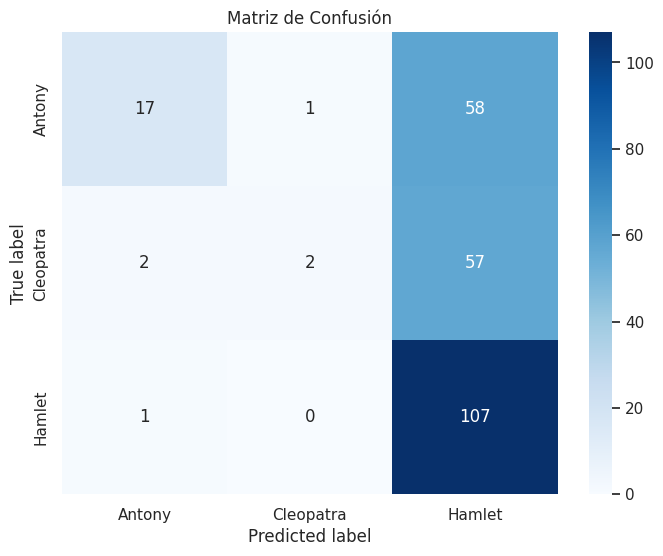

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Suponiendo que ya tienes los mejores parámetros
best_params = {"stop_words": None, "ngram_range": (1, 2), "use_idf": True}

# Preprocesamiento y vectorización de texto
count_vect = CountVectorizer(stop_words=best_params["stop_words"], ngram_range=best_params["ngram_range"])
tfidf_transformer = TfidfTransformer(use_idf=best_params["use_idf"])
X_train_counts = count_vect.fit_transform(X_train)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# Entrenamiento del modelo final con los mejores parámetros
bayes_clf = MultinomialNB().fit(X_train_tfidf, y_train)

# Predicciones sobre el conjunto de prueba
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
y_pred = bayes_clf.predict(X_test_tfidf)

# Métricas finales
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Reporte de métricas y matriz de confusión
print(f'Accuracy: {accuracy:.4f}\n')
print('Matriz de Confusión:')
print(conf_matrix)
print('\nReporte de Clasificación:')
print(class_report)

# Representación gráfica de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Matriz de Confusión')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Resultados del SVM:
Accuracy: 0.6612

Matriz de Confusión:
[[46  6 24]
 [15 24 22]
 [11  5 92]]

Reporte de Clasificación:
              precision    recall  f1-score   support

      Antony       0.64      0.61      0.62        76
   Cleopatra       0.69      0.39      0.50        61
      Hamlet       0.67      0.85      0.75       108

    accuracy                           0.66       245
   macro avg       0.66      0.62      0.62       245
weighted avg       0.66      0.66      0.65       245



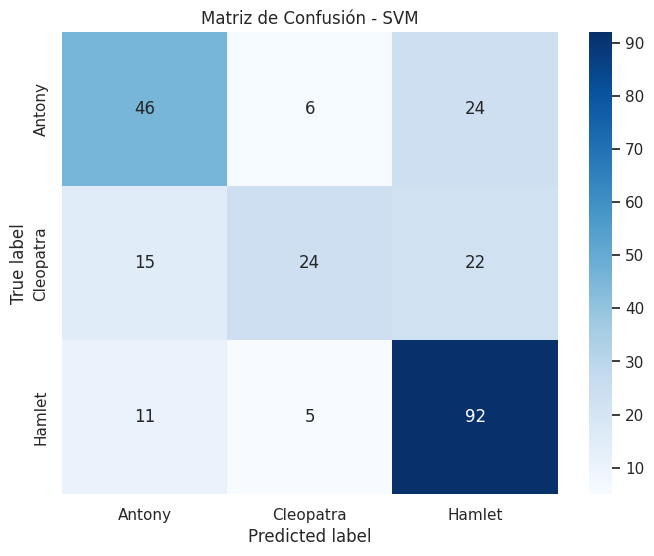

In [29]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar CountVectorizer y TfidfTransformer
count_vect = CountVectorizer(stop_words=None, ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer(use_idf=True)

# Transformar datos de entrenamiento
X_train_counts = count_vect.fit_transform(X_train)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# Entrenar modelo SVM (LinearSVC)
svm_clf = LinearSVC()
svm_clf.fit(X_train_tfidf, y_train)

# Transformar datos de prueba
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# Predicciones sobre datos de prueba
y_pred_svm = svm_clf.predict(X_test_tfidf)

# Calcular métricas de evaluación
accuracy_svm = accuracy_score(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
class_report_svm = classification_report(y_test, y_pred_svm)

# Mostrar resultados
print("Resultados del SVM:")
print(f'Accuracy: {accuracy_svm:.4f}\n')
print('Matriz de Confusión:')
print(conf_matrix_svm)
print('\nReporte de Clasificación:')
print(class_report_svm)

# Representación gráfica de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Matriz de Confusión - SVM')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


Resultados del Random Forest:
Accuracy: 0.5551

Matriz de Confusión:
[[30 21 25]
 [13 22 26]
 [ 6 18 84]]

Reporte de Clasificación:
              precision    recall  f1-score   support

      Antony       0.61      0.39      0.48        76
   Cleopatra       0.36      0.36      0.36        61
      Hamlet       0.62      0.78      0.69       108

    accuracy                           0.56       245
   macro avg       0.53      0.51      0.51       245
weighted avg       0.55      0.56      0.54       245



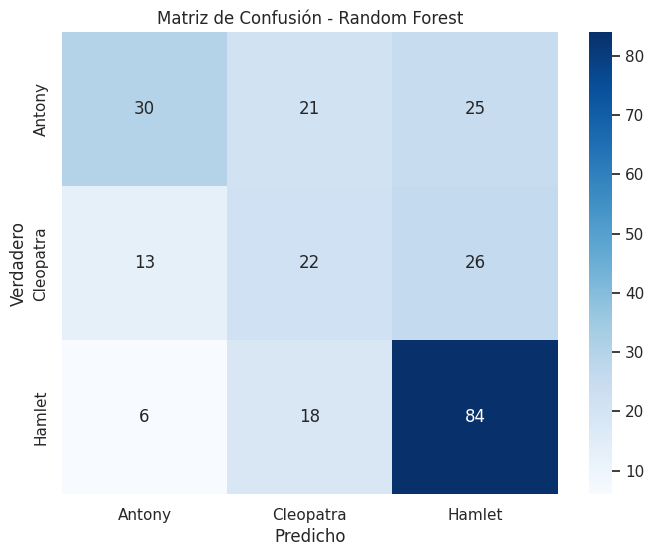

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Configurar CountVectorizer y TfidfTransformer
count_vect = CountVectorizer(stop_words=None, ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer(use_idf=True)

# Transformar datos de entrenamiento
X_train_counts = count_vect.fit_transform(X_train)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# Entrenar modelo Random Forest
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_tfidf, y_train)

# Transformar datos de prueba
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# Predicciones sobre datos de prueba
y_pred_rf = rf_clf.predict(X_test_tfidf)

# Calcular métricas de evaluación
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)

# Mostrar resultados
print("Resultados del Random Forest:")
print(f'Accuracy: {accuracy_rf:.4f}\n')
print('Matriz de Confusión:')
print(conf_matrix_rf)
print('\nReporte de Clasificación:')
print(class_report_rf)

# Representación gráfica de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Matriz de Confusión - Random Forest')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.show()


(Opcional) Comparativa con Fasttext

In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 1.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.1-py3-none-any.whl (238 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4246765 sha256=84575195bb34357019bbb550078295b1e9d21c196b67bfb54410885f5fd32bd4
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext


In [ ]:
import fasttext

y_train_s = np.char.replace(y_train.astype(str), " ", "_").astype(object)
y_test_s = np.char.replace(y_test.astype(str), " ", "_").astype(object)

# Convertimos al formato de fasttext: archivo de texto donde cada línea es:
# __label__<label> TEXTO
Xytrains = "__label__" + y_train_s.astype(object) + " " + X_train
Xytests = "__label__" + y_test_s.astype(object) + " " + X_test
np.savetxt(data_dir / "train.txt", Xytrains, fmt="%s")
np.savetxt(data_dir / "test.txt", Xytests, fmt="%s")

Xytests[0]

NameError: name 'data_dir' is not defined

In [ ]:
model = fasttext.train_supervised(input=str(data_dir / "train.txt"), epoch=100, wordNgrams=2)
model.test(str(data_dir / "test.txt"))

In [ ]:
y_out = model.predict(list(X_test))
y_pred_test = [y[0].replace("__label__", "") for y in y_out[0]]

print(get_accuracy(y_test_s, y_pred_test))